<a href="https://colab.research.google.com/github/wanwanliang/Image_Processing_and_Deep_Learning/blob/master/code/CNNs_WSR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 # Prepare data

## install and load packages

In [ ]:
!pip install geopandas
!pip install rasterio

In [ ]:
import rasterio as rio
import geopandas as gpd
import pandas as pd
import numpy as np
import os
import sklearn
import tensorflow as tf
%matplotlib inline
import matplotlib.pyplot as plt
import google.colab
from google.colab import drive
import glob

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
os.chdir("/content/drive/My Drive/UMN_Research/Data/wsr/image_200_bb45")

In [ ]:
from keras.layers import Input, Conv2D, Activation, BatchNormalization, GlobalAveragePooling2D, Dense, Dropout, AveragePooling2D, Flatten, ZeroPadding2D, MaxPooling2D, Add
from keras.activations import relu, softmax
from keras.models import Model
from keras import regularizers, initializers

In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

# Design Resnet

### Define identity block

In [ ]:
def identity_block(X,f,filters, stage, block):

  # defining name basis
  conv_name_base = 'res' + str(stage) + block + "_branch"
  bn_name_base = 'bn' + str(stage) + block + "_branch"

  F1, F2, F3 = filters

  X_shortcut = X

  # first component of main path
  X = Conv2D(filters=F1, kernel_size=(1,1), strides=(1,1), padding='valid', name = conv_name_base + '2a', kernel_initializer=initializers.glorot_uniform(seed=0))(X)
  X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
  X = Activation('relu')(X)

  # second component of main path
  X = Conv2D(filters=F2, kernel_size=(f,f), strides=(1,1), padding='same', name=conv_name_base + '2b', kernel_initializer=initializers.glorot_uniform(seed=0))(X)
  X = BatchNormalization(axis = 3, name=bn_name_base + '2b')(X)
  X =  Activation('relu')(X)

  # third component of main path
  X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = initializers.glorot_uniform(seed=0))(X)
  X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

  # final step
  X = Add()([X, X_shortcut])
  X = Activation('relu')(X)

  return X

### Define convolutional block

In [ ]:
def convolutional_block(X, f, filters, stage, block, s=2):

  # defining name basis
  conv_name_base = 'res' + str(stage) + block + "_branch"
  bn_name_base = 'bn' + str(stage) + block + "_branch"

  # Retrieve Filters
  F1, F2, F3 = filters

  X_shortcut = X

  # First component of main path 
  X = Conv2D(F1, (1,1), strides = (s,s), name= conv_name_base + "2a", kernel_initializer= initializers.glorot_uniform(seed=0))(X)
  X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
  X = Activation('relu')(X)

  # Second component of main path 
  X = Conv2D(filters= F2, kernel_size=(f,f), strides=(1,1), padding='same', name=conv_name_base + '2b', kernel_initializer= initializers.glorot_uniform(seed=0))(X)
  X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
  X = Activation('relu')(X)

  # Third component of main path 
  X = Conv2D(filters = F3, kernel_size=(1,1), strides=(1,1), padding='valid', name=conv_name_base + '2c', kernel_initializer=initializers.glorot_uniform(seed=0))(X)
  X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

  ##### SHORTCUT PATH #### 
  X_shortcut =  Conv2D(F3, (1, 1), strides = (s,s), name = conv_name_base + '1', kernel_initializer = initializers.glorot_uniform(seed=0))(X_shortcut)
  X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)

  # Final step: Add shortcut value to main path, and pass it through a RELU activation 
  X = Add()([X, X_shortcut])
  X = Activation('relu')(X)

  return X

### ResNet50

In [ ]:
def ResNet50(input_shape = (64, 64, 5), classes=2):

  X_input = Input(input_shape)

  X = ZeroPadding2D((3,3))(X_input)

  # stage 1 
  X = Conv2D(64, (3,3), strides=(2,2), name='conv1', kernel_initializer=initializers.glorot_uniform(seed=0))(X)
  X = BatchNormalization(axis=3, name='bn_conv1')(X)
  X = Activation('relu')(X)
  X = MaxPooling2D((3,3), strides=(2,2), padding='same')(X)
  
  # stage 2
  X = convolutional_block(X, f=3, filters=[64, 64, 256], stage=2, block='a', s=1)
  X = identity_block(X, 3, [64,64,256], stage=2, block='b')
  X = identity_block(X, 3, [64,64,256], stage=2, block='c')

  # stage 3
  X = convolutional_block(X, f=3, filters=[128, 128, 512], stage=3, block='a', s=2)
  X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
  X = identity_block(X, 3, [128,128,512], stage=3, block='c')
  X = identity_block(X, 3, [128,128,512], stage=3, block='d')

  # stage 4
  X = convolutional_block(X, f=3, filters=[256,256,1024], stage=4, block='a', s=2)
  X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
  X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
  X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
  X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
  X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

  # stage 5
  X = convolutional_block(X, f = 3, filters = [512, 512, 2048], stage = 5, block='a', s = 2)
  X = identity_block(X, 3, [512,512, 2048], stage=5, block='b')
  X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

  # averge pooling
  X = AveragePooling2D(name='avg_pool', padding='same')(X)

  # output layer
  X = Flatten()(X)
  X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer= initializers.glorot_uniform(seed=0))(X)

  # create model
  model = Model(inputs = X_input, outputs= X, name='ResNet50')

  return model

### ResNet18

In [ ]:
def ResNet18(input_shape = (64, 64, 5), classes=2):

  X_input = Input(input_shape)

  X = ZeroPadding2D((3,3))(X_input)

  # stage 1 
  X = Conv2D(64, (3,3), strides=(2,2), name='conv1', kernel_initializer=initializers.glorot_uniform(seed=0))(X)
  X = BatchNormalization(axis=3, name='bn_conv1')(X)
  X = Activation('relu')(X)
  X = MaxPooling2D((3,3), strides=(1,1), padding='same')(X)
  
  # stage 2
  X = convolutional_block(X, f=3, filters=[64, 64, 256], stage=2, block='a', s=1)
  X = identity_block(X, 3, [64,64,256], stage=2, block='b')


  # stage 3
  X = convolutional_block(X, f=3, filters=[128, 128, 512], stage=3, block='a', s=2)
  X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')


  # stage 4
  X = convolutional_block(X, f=3, filters=[256,256,1024], stage=4, block='a', s=2)
  X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')


  # stage 5
  X = convolutional_block(X, f = 3, filters = [512, 512, 2048], stage = 5, block='a', s = 2)
  X = identity_block(X, 3, [512,512, 2048], stage=5, block='b')


  # averge pooling
  X = AveragePooling2D(name='avg_pool', padding='same')(X)

  # output layer
  X = Flatten()(X)
  X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer= initializers.glorot_uniform(seed=0))(X)

  # create model
  model = Model(inputs = X_input, outputs= X, name='ResNet50')

  return model

# Load and prepare data

In [ ]:
os.chdir('/content/drive/Shared drives/WSR_data/Drone200ft/Multispectral_LargerPlotSize')

### list and order files

In [ ]:
import glob
t = glob.glob("*.tif")
# t2 = sorted(t)
# os.remove('plot621 (1).tif')
print(len(t))
t[:10]

960


['plot598.tif',
 'plot482.tif',
 'plot624.tif',
 'plot574.tif',
 'plot520.tif',
 'plot560.tif',
 'plot636.tif',
 'plot501.tif',
 'plot541.tif',
 'plot587.tif']

In [ ]:
nbs = []
[nbs.append(int((td.split('plot')[1]).split('.')[0])) for td in t]
nbs[:10]

[598, 482, 624, 574, 520, 560, 636, 501, 541, 587]

In [ ]:
all = zip(nbs, t)
sorted_all = sorted(all)

In [ ]:
t_sorted = [x for y, x in sorted_all]

In [ ]:
t_sorted[:10]

['plot1.tif',
 'plot2.tif',
 'plot3.tif',
 'plot4.tif',
 'plot5.tif',
 'plot6.tif',
 'plot7.tif',
 'plot8.tif',
 'plot9.tif',
 'plot10.tif']

### load all images in one numpy array

In [ ]:
def tif2ary(tif):

  raA = rio.open(tif)
  arys = raA.read()

  arys= arys.astype('float32')
  arys =np.moveaxis(arys, 0, -1)

  
  return(arys)

In [ ]:
dt = None

for tif in t_sorted:

  ary = tif2ary(tif)
  ary = ary[1:33, 1:33:,]

  # resize image array to 64*64
  ary = np.repeat(ary, 2, axis=1)
  ary = np.repeat(ary, 2, axis=0)

  ary = ary.reshape((1, 64, 64,5))

  if dt is None:
    dt = ary
  else:
    dt = np.concatenate((dt, ary), axis=0)

In [ ]:
dt.shape

(960, 64, 64, 5)

In [ ]:
min_val = [np.min(dt[:,:,:,i]) for i in range(5)]
print(min_val)

[3707.8135, 3668.7615, 2762.414, 12326.874, 3777.8079]


In [ ]:
max_val = [np.max(dt[:,:,:,i]) for i in range(5)]
print(max_val)
dt = dt/max_val
print([np.max(dt[:,:,:,i]) for i in range(5)])

[64268.277, 60118.1, 35737.86, 236070.98, 52668.152]
[1.0, 1.0, 1.0, 1.0, 1.0]


In [ ]:
y = pd.read_csv("../labels.csv")
print(y.shape)
y[:5]

(960, 8)


,plot_ID,binary_1,score,resistance,resistance_class_4,binary_2,block,variety
0,1,1,50.0,S,S,S,2,DH058
1,2,1,5.0,RMR,MR,R,2,Faller
2,3,1,25.0,MSS,S,S,2,DH121
3,4,1,40.0,MSS,S,S,2,DH80
4,5,1,25.0,MSS,S,S,2,ROB


In [ ]:
y.binary_1.value_counts()

0    483
1    477
Name: binary_1, dtype: int64

In [ ]:
y = y['binary_1']
y = np.asarray(y).reshape((-1,1))
y.shape

(960, 1)

In [ ]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
encoder.fit(y)
y = encoder.transform(y)
y.shape

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(960,)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(dt, y, random_state=16, shuffle=True, test_size=0.1)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, random_state=16, test_size=0.15)

print("Train size is: {}".format(x_train.shape[0]))
print("Test size is: {}".format(x_test.shape[0]))
print("Validation size is: {}".format(x_val.shape[0]))

Train size is: 734
Test size is: 96
Validation size is: 130


In [ ]:
x_train.shape

(734, 64, 64, 5)

In [ ]:
ts = x_train[0]
print(np.min(ts))
print(np.max(ts))

0.118229024
0.72910243



# DL Model Training

In [ ]:
#model = ResNet50(input_shape=(64, 64, 5), classes=2)
model = ResNet18(input_shape=(64, 64, 5), classes=2)

In [ ]:
model.compile(optimizer= tf.keras.optimizers.Adam(lr=0.005),loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
earlyStopping = EarlyStopping(monitor='val_loss', patience=50, verbose=0, mode='min')
mcp_save = ModelCheckpoint('.mdl_wts.hdf5', save_best_only=True, monitor='val_loss', mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=20, verbose=1, epsilon=1e-4, min_lr = 0.0001, mode='auto')

In [ ]:
model.fit(x_train, y_train, epochs=200, batch_size=16, validation_data=(x_val, y_val), callbacks=[earlyStopping, mcp_save, reduce_lr_loss])

Epoch 1/200
46/46 [==============================] - 128s 3s/step - loss: 9.8398 - accuracy: 0.5391 - val_loss: 3218.0862 - val_accuracy: 0.5000
Epoch 2/200
46/46 [==============================] - 125s 3s/step - loss: 5.7842 - accuracy: 0.5441 - val_loss: 739.0918 - val_accuracy: 0.4846
Epoch 3/200
46/46 [==============================] - 125s 3s/step - loss: 4.7011 - accuracy: 0.5254 - val_loss: 169.0479 - val_accuracy: 0.4385
Epoch 4/200
46/46 [==============================] - 124s 3s/step - loss: 1.9325 - accuracy: 0.5897 - val_loss: 0.7299 - val_accuracy: 0.5077
Epoch 5/200
46/46 [==============================] - 124s 3s/step - loss: 1.9342 - accuracy: 0.5680 - val_loss: 1.1383 - val_accuracy: 0.6385
Epoch 6/200
46/46 [==============================] - 124s 3s/step - loss: 1.7007 - accuracy: 0.6061 - val_loss: 0.7961 - val_accuracy: 0.5769
Epoch 7/200
46/46 [==============================] - 125s 3s/step - loss: 1.0855 - accuracy: 0.6228 - val_loss: 1.2085 - val_accuracy: 0.6077

## Model evaluation

In [ ]:
y_test_pred = model.predict_classes(x_test)
print('Testing accuracy is {}'.format(accuracy_ssocre(y_test, y_test_pred)))

In [ ]:
print ('Confusion matrix:')
print(confusion_matrix(y_test, y_test_pred))

# ML Models

## Read data

In [ ]:
os.chdir("/content/drive/My Drive/UMN_Research/Data/wsr")
dt = pd.read_csv('data.csv')

In [ ]:
dt2=dt
dt2 = dt2.drop(['plotID'],axis=1)
dt2.shape

dt2['class2']=0
dt2['class2'].iloc[(dt2.block==2)|(dt2.block==3)|(dt2.block==6)]=1

dt2['class2'].value_counts()
dt3 = dt2
dt3 = dt3.drop(['score','resistance_class_4','binary_2','block'],axis=1)
print(dt3.shape)
dt3.head(5)

(960, 27)


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X0.1,X1.1,X2.1,X3.1,X4.1,X5.1,X6.1,X7.1,X8.1,X9.1,class2
0,26054.19412,52866618.51,27137.44510,80548746.36,14667.25294,1.589171e+07,2433.612745,557978.0798,1257.693382,158689.7290,1456.209804,143218.4589,112914.0471,1.421580e+09,27501.67451,75384230.79,0.615409,0.002284,4.283037,0.453224,0.713874,0.003074,1.024282,0.014584,0.008424,0.003617,1
1,25070.41186,37842286.10,31685.62109,84783325.68,15492.49259,1.676155e+07,2612.958608,526833.6568,1406.612026,170621.2991,1565.959638,171643.2074,146421.5091,1.453161e+09,31807.99012,65577156.25,0.704512,0.001126,5.860475,0.672441,0.817233,0.001515,1.251328,0.019539,0.108141,0.003200,1
2,22230.05606,26873360.55,27711.32369,59799946.18,13979.20796,1.316616e+07,2313.010172,528174.2624,1237.74288,176488.4922,1419.730108,169724.9701,122329.3743,1.068322e+09,27098.23870,52039725.92,0.687366,0.001441,5.492526,0.629666,0.797343,0.001940,1.235449,0.023648,0.101059,0.003888,1
3,18318.64190,14563155.19,23536.30312,37585325.99,11938.37296,7.414469e+06,2124.877043,315337.9990,1145.411961,102229.5704,1322.807114,101101.1512,114833.4978,9.289586e+08,23970.07281,36346660.18,0.718340,0.001541,6.238550,1.001685,0.833273,0.002073,1.272672,0.025078,0.115595,0.004000,1
4,22268.81983,32827768.94,27141.65455,67524584.21,14028.76694,1.428309e+07,2498.169835,555439.8466,1320.919731,170685.0399,1508.353512,172552.6236,111148.3901,9.671520e+08,26259.21983,51535493.86,0.661185,0.001646,4.990535,0.546901,0.766974,0.002215,1.205786,0.026049,0.088361,0.004602,1


In [ ]:
pd.isnull(dt3).any(axis=0)
dt4 = dt3.dropna(axis=0)
print(dt4.shape)

(959, 27)


In [ ]:
from sklearn.ensemble import BaggingClassifier as bc
from sklearn.tree import DecisionTreeClassifier as dtc
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons
from sklearn.ensemble import RandomForestClassifier as rfc
from sklearn.ensemble import VotingClassifier as vc
from sklearn.linear_model import LogisticRegression as lrc
from sklearn.svm import SVC as svc
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [ ]:
x, y = dt4.drop(['class2'], axis=1), dt4['class2']
x = StandardScaler().fit_transform(x)

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=16, shuffle=True, test_size=0.1)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, random_state=16, test_size=0.15)

print("Train size is: {}".format(x_train.shape[0]))
print("Test size is: {}".format(x_test.shape[0]))
print("Validation size is: {}".format(x_val.shape[0]))

Train size is: 733
Test size is: 96
Validation size is: 130


## RF and SVM Models

In [ ]:
rf_clf = rfc(n_estimators=500, random_state=6) 
svm_clf = svc(gamma='scale', random_state=6)

rf_clf.fit(x_train, y_train)
svm_clf.fit(x_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=6, shrinking=True, tol=0.001,
    verbose=False)

In [ ]:
y_pred_rf = rf_clf.predict(x_test)
y_pred_svm = svm_clf.predict(x_test)

In [ ]:
from sklearn.metrics import accuracy_score

print("Test Accuracy by RF: {}".format(accuracy_score(y_test, y_pred_rf)))
print("Test Accuracy by SVM: {}".format(accuracy_score(y_test, y_pred_svm)))

Test Accuracy by RF: 0.8229166666666666
Test Accuracy by SVM: 0.7395833333333334


In [ ]:
from sklearn.metrics import confusion_matrix
print("Confusion matrix by RF:")
print(confusion_matrix(y_test, y_pred_rf))

print("")
print("Confusion matrix by SVM:")
print(confusion_matrix(y_test, y_pred_svm))

Confusion matrix by RF:
[[44  9]
 [ 8 35]]

Confusion matrix by SVM:
[[43 10]
 [15 28]]


In [ ]:
y_pred_rf = rf_clf.predict(x_val)
y_pred_svm = svm_clf.predict(x_val)

print("Validation Accuracy by RF: {}".format(accuracy_score(y_val, y_pred_rf)))
print("Validation Accuracy by SVM: {}".format(accuracy_score(y_val, y_pred_svm)))

Validation Accuracy by RF: 0.7538461538461538
Validation Accuracy by SVM: 0.7076923076923077


## MLP Model

In [ ]:
import tensorflow as tf
from tensorflow import keras

In [ ]:
mlp_model = keras.models.Sequential()
mlp_model.add(Dense(30, input_dim = 26, activation='relu'))
mlp_model.add(Dense(30, activation='relu'))
mlp_model.add(Dense(2, activation='sigmoid'))

In [ ]:
mlp_model.compile(loss='sparse_categorical_crossentropy',
                  optimizer = keras.optimizers.Adam(learning_rate=0.01),
                  metrics=['accuracy'])

In [ ]:
fit_history = mlp_model.fit(x_train, y_train, epochs=200,batch_size=16,verbose=0, validation_data=(x_val, y_val))

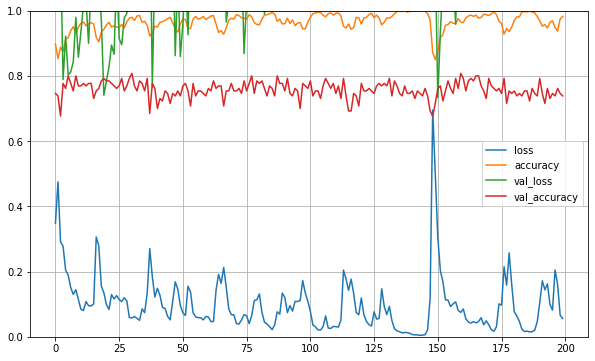

In [ ]:
pd.DataFrame(fit_history.history).plot(figsize=(10,6))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

In [ ]:
y_pred_mlp = mlp_model.predict_classes(x_test)
print("Test Accuracy by MLP: {}".format(accuracy_score(y_test, y_pred_mlp)))

print("Confusion matrix by MLP:")
print(confusion_matrix(y_test, y_pred_mlp))

Test Accuracy by MLP: 0.78125
Confusion matrix by MLP:
[[44  9]
 [12 31]]


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [ ]:
y_pred_mlp = mlp_model.predict_classes(x_val)
print("Validation Accuracy by MLP: {}".format(accuracy_score(y_val, y_pred_mlp)))

print("Confusion matrix by MLP:")
print(confusion_matrix(y_val, y_pred_mlp))

Validation Accuracy by MLP: 0.7384615384615385
Confusion matrix by MLP:
[[51 13]
 [21 45]]


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
